In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
def standard_error(series):
    return series.std() / np.sqrt(series.count())

def process_data(new_file_path, previous_df=None):
    """
    Processes the experiment data from a new CSV file. If a previous DataFrame is provided,
    appends the new data to it; otherwise, creates a new DataFrame.

    Parameters:
    previous_df (pandas.DataFrame, optional): The existing DataFrame to append to. Defaults to None.
    new_file_path (str): The file path to the new CSV file containing the experiment data.

    Returns:
    pandas.DataFrame: A DataFrame with the combined data.
    """
    # Load the data from the new CSV file
    new_data = pd.read_csv(new_file_path)

    # Add a new column for method_name based on the value of method
    new_data['method_name'] = new_data.apply(lambda x: x['prune_method'] if x['method'] == 'prune' else x['quant_method'] if x['method'] == 'quant' else None, axis=1)
    new_data['method_name'] = new_data['method_name'].replace({'autoawq': 'AWQ', 'autogptq': 'GPTQ', 'sparsegpt': 'SparseGPT', 'wanda': 'Wanda'})

    # Selecting only relevant columns for aggregation
    aggregation_columns = ['Rewrite accuracy', 'PPL', 'Generalization', 'Latency', 'Locality', 'PPL edits']

    # Group by 'Tags' and calculate mean and standard error for the selected columns
    grouped_new_data = new_data.groupby('Tags')[aggregation_columns].agg(['mean', standard_error])

    # Flatten multi-level columns and rename them
    grouped_new_data.columns = ['_'.join(col).strip() for col in grouped_new_data.columns.values]

    # Merge the grouped new data with the extracted information
    final_new_df = pd.merge(grouped_new_data.reset_index(), new_data[['Tags', 'alg_name', 'edit', 'compress', 'sparsity_ratio', 'method_name', 'Average bits']], 
                            on='Tags', how='left').drop_duplicates()

    # Reordering columns
    final_cols = ['alg_name', 'edit', 'compress', 'sparsity_ratio', 'method_name'] + \
                 [col for col in final_new_df.columns if col not in ['alg_name', 'edit', 'compress', 'sparsity_ratio', 'Tags', 'method_name']]
    final_new_df = final_new_df[final_cols]

    # If a previous DataFrame is provided, append the new data; otherwise, use the new data as the DataFrame
    if previous_df is not None:
        combined_df = pd.concat([previous_df, final_new_df], ignore_index=True)
    else:
        combined_df = final_new_df

    return combined_df



In [5]:
# No edits
unedited_counterfact = process_data('data/noedits.csv')
# unedited_counterfact = process_data('data/w4gptq_counterfact.csv', unedited_counterfact)
# unedited_counterfact = process_data('data/w8gptq_counterfact.csv', unedited_counterfact)
# unedited_counterfact = process_data('data/w8gptq_counterfact.csv', unedited_counterfact)
# unedited_counterfact = process_data('data/w4awq_counterfact.csv', unedited_counterfact)

# With MEMIT
edited_counterfact = process_data('data/withedits.csv')
# edited_counterfact = process_data('data/w4gptq_edits_counterfact.csv', edited_counterfact)
# edited_counterfact = process_data('data/w8gptq_edits_counterfact.csv', edited_counterfact)
# edited_counterfact = process_data('data/w8gptq_edits_counterfact.csv', edited_counterfact)
# edited_counterfact = process_data('data/w4awq_edits_counterfact.csv', edited_counterfact)

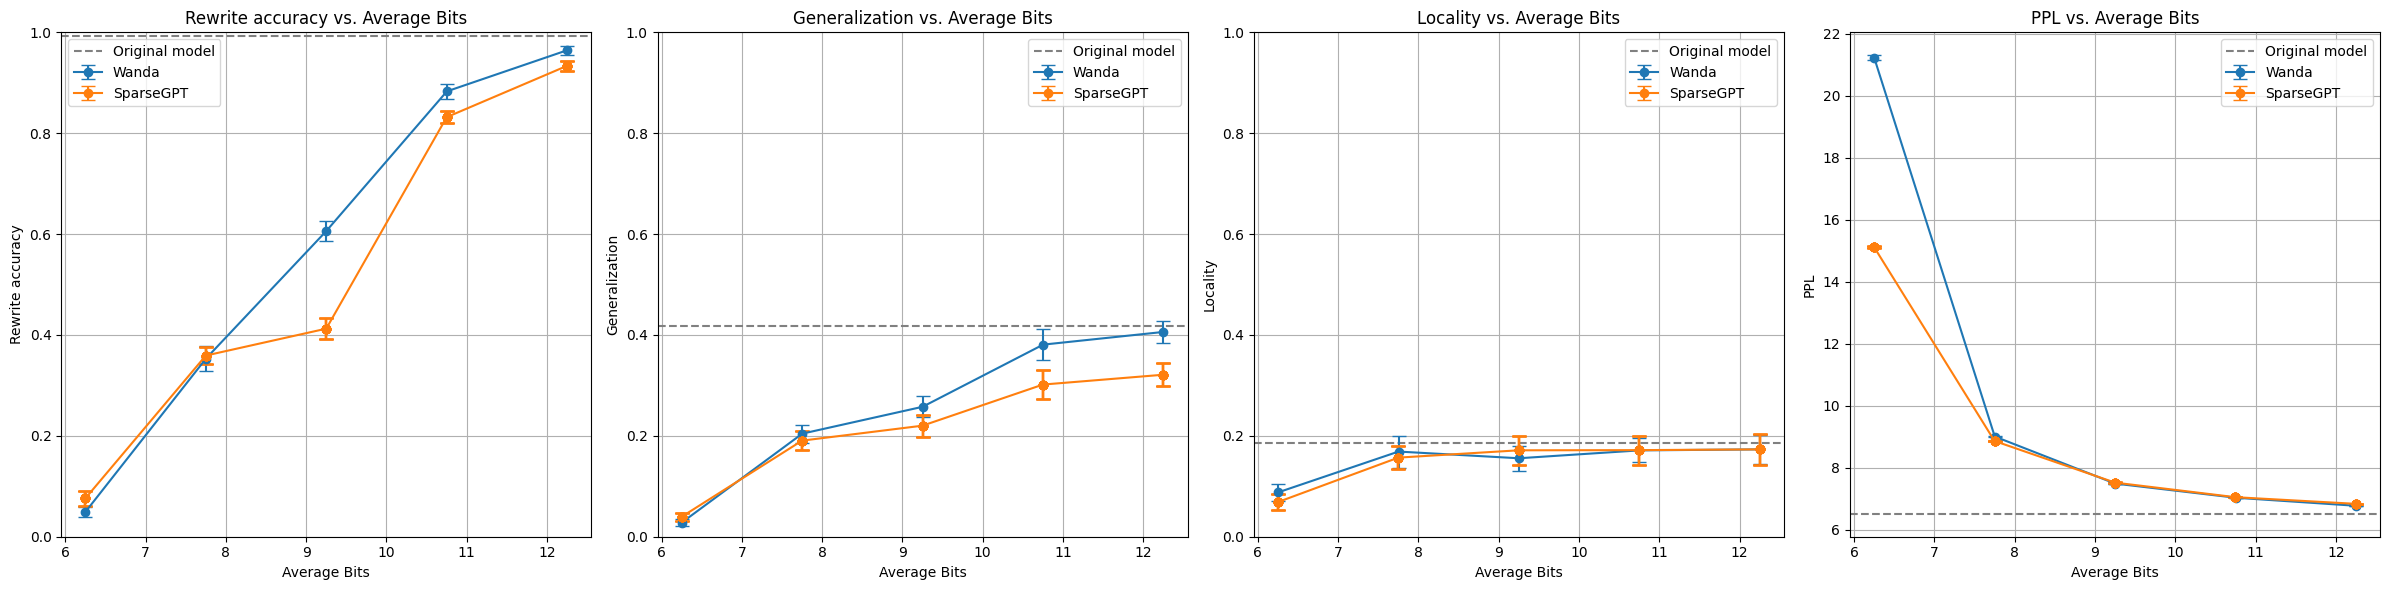

In [6]:

"""
Creates subplots for different metrics from the given DataFrame.

Parameters:
df (pandas.DataFrame): The DataFrame containing the experiment data.

The function generates a plot with four subfigures:
- Rewrite accuracy vs. sparsity ratio
- Generalization vs. sparsity ratio
- Locality vs. sparsity ratio
- Perplexity vs. sparsity ratio
"""
# Define the metrics to plot
df = edited_counterfact

metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Iterate over each metric and subplot
for i, metric in enumerate(metrics):
    # Extract and plot baseline data as a horizontal dotted line
    baseline_value = df[df['sparsity_ratio'] == 0][metric].mean()
    axs[i].axhline(y=baseline_value, color='gray', linestyle='--', label='Original model')

    # Plot each method in the dataset, excluding the baseline
    for method in df[df['sparsity_ratio'] != 0]['method_name'].unique():
        method_data = df[(df['method_name'] == method) & (df['sparsity_ratio'] != 0)]
        axs[i].errorbar(method_data['Average bits'], method_data[metric], 
                        yerr=method_data[metric.replace('mean', 'standard_error')], 
                        fmt='o-', label=method, capsize=5)

    axs[i].set_xlabel('Average Bits')
    axs[i].set_ylabel(metric.split('_')[0])
    axs[i].set_title(f'{metric.split("_")[0]} vs. Average Bits')
    axs[i].legend()
    axs[i].grid(True)

    # Invert x-axis to have high average bits on the left and low on the right
    # axs[i].invert_xaxis()

    # Set y-axis limits to 0 to 1 for the first three subplots
    if i < 3:
        axs[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

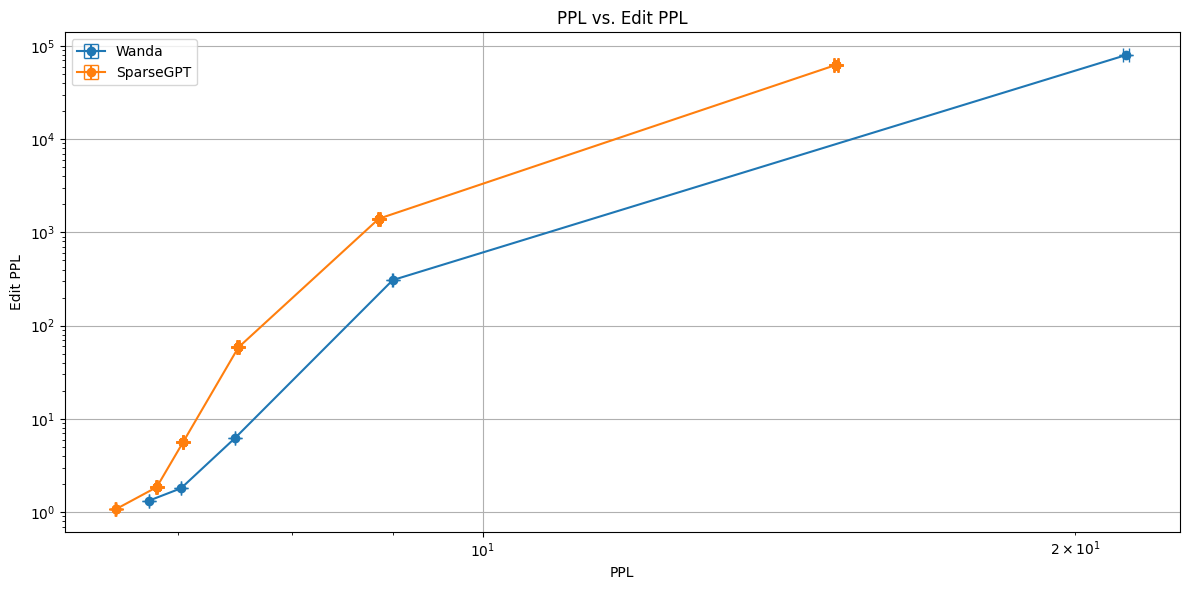

In [86]:
def create_ppl_vs_edit_ppl_plot(df):
    """
    Creates a plot for PPL vs. edit PPL from the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the experiment data.

    The function generates a plot:
    - PPL vs. edit PPL
    """
    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each method, only if PPL is below 10000
    for method in df['method_name'].unique():
        method_data = df[(df['method_name'] == method) & (df['PPL edits_mean'] < np.inf)]
        ax.errorbar(method_data['PPL_mean'], method_data['PPL edits_mean'], 
                    xerr=method_data['PPL_standard_error'], yerr=method_data['PPL_standard_error'],
                    fmt='o-', label=method, capsize=5)

    ax.set_xlabel('PPL')
    ax.set_ylabel('Edit PPL')
    ax.set_title('PPL vs. Edit PPL')
    ax.legend()
    ax.grid(True)

    # plt.axis('square')
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

# Example usage
create_ppl_vs_edit_ppl_plot(edited_counterfact)
